# Glass structure - evolutionary approach

In [1]:
import numpy as np

In [2]:
rng = np.random.default_rng()

## Data preparation and utility functions

In [3]:
from itertools import dropwhile, takewhile
import re

def read_atoms(input_path):
    with open(input_path, 'r') as file:
        lines = file.readlines()
        
        atom_spec_lines = list(takewhile(lambda line: line != 'ATOMIC_POSITIONS (angstrom)\n', dropwhile(lambda line: line != 'ATOMIC_SPECIES\n', lines)))[1:]
        atom_species_by_index = {i: symbol for i, symbol in enumerate([line.split()[0] for line in atom_spec_lines])}
        atom_species_by_symbol = {symbol: i for i, symbol in atom_species_by_index.items()}
        
        atom_pos_lines = list(dropwhile(lambda line: line != 'ATOMIC_POSITIONS (angstrom)\n', lines))[1:-2]
        atom_positions = [(float(x), float(y), float(z), atom_species_by_symbol[symbol]) for symbol, x, y, z in [line.split() for line in atom_pos_lines]]

        cell_size_line = next(line for line in lines if line.startswith('  ibrav'))
        cell_size_match = re.search(r'a=(\d+(\.\d+)?)', cell_size_line)
        cell_size = float(cell_size_match.group(1)) if cell_size_match else None

    return atom_species_by_index, atom_species_by_symbol, np.array(atom_positions), cell_size

In [4]:
def get_solution_size(cluster_size, solution_thickness, axis):
    # TODO: adjust to local solutions approach (for axes Y and Z)
    match axis:
        case 0:
            size_x = solution_thickness
            size_y = cluster_size
            size_z = cluster_size
        case 1:
            size_x = cluster_size + solution_thickness
            size_y = solution_thickness
            size_z = cluster_size
        case 2:
            size_x = cluster_size + solution_thickness
            size_y = cluster_size + solution_thickness
            size_z = solution_thickness

    return size_x, size_y, size_z

In [5]:
def get_atoms_in_cuboid(atoms, min_x, max_x, min_y, max_y, min_z, max_z):
    return atoms[
        (atoms[:, 0] > min_x)
        & (atoms[:, 0] < max_x)
        & (atoms[:, 1] > min_y)
        & (atoms[:, 1] < max_y)
        & (atoms[:, 2] > min_z)
        & (atoms[:, 2] < max_z)
    ]


def cut_atoms(atoms, center, x_size, y_size, z_size):
    x_min, x_max = center[0] - x_size/2, center[0] + x_size/2
    y_min, y_max = center[1] - y_size/2, center[1] + y_size/2
    z_min, z_max = center[2] - z_size/2, center[2] + z_size/2

    center_coords = np.array(np.concat([center[:3], [0]]))

    return get_atoms_in_cuboid(atoms, x_min, x_max, y_min, y_max, z_min, z_max) - center_coords

In [6]:
def get_positioned_walls_x(cluster, cluster_size, wall_thickness, solution_thickness):
    wall_x_left = cluster[cluster[:, 0] < -cluster_size / 2 + wall_thickness]
    wall_x_right = cluster[cluster[:, 0] > cluster_size / 2 - wall_thickness]

    wall_x_left_shifted = wall_x_left + np.array([cluster_size/2 + solution_thickness/2, 0, 0, 0])
    wall_x_right_shifted = wall_x_right - np.array([cluster_size/2 + solution_thickness/2, 0, 0, 0])

    return wall_x_left_shifted, wall_x_right_shifted


def get_positioned_walls_y(solution_x, cluster, cluster_size, wall_thickness, solution_thickness):
    atoms = np.concat([cluster, solution_x])

    wall_y_bottom = atoms[atoms[:, 1] < -cluster_size / 2 + wall_thickness]
    wall_y_top = atoms[atoms[:, 1] > cluster_size / 2 - wall_thickness]

    wall_y_bottom_shifted = wall_y_bottom + np.array([0, cluster_size/2 + solution_thickness/2, 0, 0])
    wall_y_top_shifted = wall_y_top - np.array([0, cluster_size/2 + solution_thickness/2, 0, 0])

    return wall_y_bottom_shifted, wall_y_top_shifted


def get_positioned_walls_z(solution_x, solution_y, cluster, cluster_size, wall_thickness, solution_thickness):
    atoms = np.concat([cluster, solution_x, solution_y])

    wall_z_back = atoms[atoms[:, 2] < -cluster_size / 2 + wall_thickness]
    wall_z_front = atoms[atoms[:, 2] > cluster_size / 2 - wall_thickness]

    wall_z_back_shifted = wall_z_back + np.array([0, 0, cluster_size/2 + solution_thickness/2, 0])
    wall_z_front_shifted = wall_z_front - np.array([0, 0, cluster_size/2 + solution_thickness/2, 0])

    return wall_z_back_shifted, wall_z_front_shifted

In [7]:
def get_random_solution(supercell, cell_size, x_size, y_size, z_size):
    center = rng.uniform(-cell_size/2, cell_size/2, 3)
    return cut_atoms(supercell, center, x_size, y_size, z_size)


def get_random_solution_without_Er(supercell, cell_size, atom_species_by_symbol, x_size, y_size, z_size):
    solution = get_random_solution(supercell, cell_size, x_size, y_size, z_size)
    while np.any(solution[:, 3] == atom_species_by_symbol['Er']):
        solution = get_random_solution(supercell, cell_size, x_size, y_size, z_size)

    return solution


def get_n_random_solutions_without_Er(supercell, cell_size, atom_species_by_symbol, cluster_size, solution_thickness, axis, n):
    x_size, y_size, z_size = get_solution_size(cluster_size, solution_thickness, axis)

    return [get_random_solution_without_Er(supercell, cell_size, atom_species_by_symbol, x_size, y_size, z_size) for _ in range(n)]

In [8]:
from itertools import product

def get_supercell(cell, cell_size):
    shift_options = [-cell_size, 0, cell_size]
    return np.concat([cell + np.array(shift_vector + (0,)) for shift_vector in product(shift_options, repeat=3)])

In [9]:
def get_Er_clusters(supercell, cluster_size, atom_species_by_symbol):
    atoms_Er = supercell[supercell[:, 3] == atom_species_by_symbol['Er']]
    return [cut_atoms(supercell, center, cluster_size, cluster_size, cluster_size) for center in atoms_Er]

In [10]:
def replace_cations_with_Si(atom_groups, atom_species_by_symbol):
    def replace_with_Si(atoms):
        modified_atoms = atoms.copy()
        modified_atoms[atoms[:, 3] != atom_species_by_symbol['O'], 3] = atom_species_by_symbol['Si']
        return modified_atoms
    
    return [replace_with_Si(atoms) for atoms in atom_groups]

In [11]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.colors import sample_colorscale
import pandas as pd


def plot_atoms_with_default_colors(atoms, atom_species_by_index, marker_symbols, text, show_legend):
    df = pd.DataFrame(atoms, columns=['x', 'y', 'z', 'species'])
    df['species'] = [atom_species_by_index[i] for i in atoms[:, 3]]
    df['text'] = text
    fig = px.scatter_3d(df, x='x', y='y', z='z', color='species', labels={'species': 'Species'}, custom_data=['text'])
    fig.update_traces(marker=dict(size=5, opacity=0.8, symbol=marker_symbols), text=text, hovertemplate='%{customdata[0]}', showlegend=show_legend)

    return fig


def plot_atoms_with_custom_colors(atoms, marker_symbols, colors, colorscale, text, colorbar_title=None):
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=atoms[:, 0],
        y=atoms[:, 1],
        z=atoms[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=colors,
            colorscale=colorscale,
            showscale=True,
            colorbar=dict(title=colorbar_title),
            symbol=marker_symbols,
            opacity=0.8
        ),
        text=text,
        hoverinfo='text',
        showlegend=False
    ))

    return fig


def plot_lines(endpoints, colors, colorscale, texts, colorbar_title, fig):
    if type(colors) is str:
        colors_precomputed = [colors] * len(endpoints)
        line_properties = lambda color: dict(color=color, width=3)
        marker_properties = dict(showscale=False)

    else:
        colors_normalized = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))
        colors_precomputed = sample_colorscale(colorscale, colors_normalized)

        line_properties = lambda color: dict(color=color, colorscale=colorscale, cmin=np.min(colors), cmax=np.max(colors), width=3)
        marker_properties = dict(colorscale=colorscale, showscale=True, cmin=np.min(colors), cmax=np.max(colors), colorbar=dict(title=colorbar_title))

    for line, color, text in zip(endpoints, colors_precomputed, texts):
        fig.add_trace(go.Scatter3d(
            x=[line[0][0], line[1][0]],
            y=[line[0][1], line[1][1]],
            z=[line[0][2], line[1][2]],
            mode='lines',
            line=line_properties(color),
            text=text,
            hoverinfo='text',
            showlegend=False,
        ))

    fig.add_trace(go.Scatter3d(
        x=[None],
        y=[None],
        z=[None],
        mode='markers',
        marker=marker_properties,
        hoverinfo='skip',
        showlegend=False
    ))


def plot_atom_connections(atoms, atom_species_by_symbol, fig):
    conn_distance_O_O = 2.5
    conn_distance_Si_Si = 2.9
    conn_distance_Si_O = 1.9

    atoms_O = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    atoms_Si = atoms[atoms[:, 3] == atom_species_by_symbol['Si']]

    dist_O_O = np.linalg.norm(atoms_O[:, None, :3] - atoms_O[:, :3], axis=-1)
    dist_Si_Si = np.linalg.norm(atoms_Si[:, None, :3] - atoms_Si[:, :3], axis=-1)
    dist_Si_O = np.linalg.norm(atoms_Si[:, None, :3] - atoms_O[:, :3], axis=-1)

    neighs_O_O_indices = np.argwhere(np.logical_and(dist_O_O > 0, dist_O_O < conn_distance_O_O))
    neighs_Si_Si_indices = np.argwhere(np.logical_and(dist_Si_Si > 0, dist_Si_Si < conn_distance_Si_Si))
    neighs_Si_O_indices = np.argwhere(np.logical_and(dist_Si_O > 0, dist_Si_O < conn_distance_Si_O))

    neighs_O_O = np.array([(atoms_O[i], atoms_O[j]) for i, j in neighs_O_O_indices])
    neighs_Si_Si = np.array([(atoms_Si[i], atoms_Si[j]) for i, j in neighs_Si_Si_indices])
    neighs_Si_O = np.array([(atoms_Si[i], atoms_O[j]) for i, j in neighs_Si_O_indices])

    if len(neighs_O_O) == 0 and len(neighs_Si_Si) == 0 and len(neighs_Si_O) == 0:
        return

    neighs = np.concat([n for n in [neighs_O_O, neighs_Si_Si, neighs_Si_O] if len(n) > 0])

    for pair in neighs:
        fig.add_trace(go.Scatter3d(
            x=[pair[0][0], pair[1][0]],
            y=[pair[0][1], pair[1][1]],
            z=[pair[0][2], pair[1][2]],
            mode='lines',
            line=dict(
                color='black',
                width=1,
                showscale=False
            ),
            hoverinfo='skip',
            showlegend=False
        ))


def setup_scene(fig, title):
    fig.update_layout(
        scene=dict(
            aspectmode='data',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10),
        title=dict(text=title, automargin=True, xanchor='center', yanchor='top', x=0.5, y=0.95)
    )
    

def plot_atoms(atoms, atom_species_by_index, atom_species_by_symbol, custom_continuous_colors=None, symbols=None, text=None, colorbar_title=None, title=None, custom_lines=None, custom_lines_colors=None, custom_lines_text=None):   
    '''
    atoms: np.array of shape (n_atoms, 4) where the columns are x, y, z, species_index
    atom_species_by_index: dict mapping species index to species symbol
    atom_species_by_symbol: dict mapping species symbol to species index
    custom_continuous_colors: np.array of shape (n_atoms,) with the colors for each atom
    symbols: list of symbols for each atom
    text: list of text for each atom
    colorbar_title: title for the colorbar
    title: title for the plot
    custom_lines: list of pairs of endpoints for lines to be plotted
    custom_lines_colors: np.array of shape (n_lines,) with the colors for each line
    custom_lines_text: list of text for each line
    '''

    colorscale = 'Viridis'
    
    if symbols is None:
        symbols = 'circle'

    if text is None:
        text = [atom_species_by_index[i] for i in atoms[:, 3]]

    if custom_continuous_colors is None:
        show_legend = custom_lines is None
        fig = plot_atoms_with_default_colors(atoms, atom_species_by_index, symbols, text, show_legend)
    else:
        fig = plot_atoms_with_custom_colors(atoms, symbols, custom_continuous_colors, colorscale, text, colorbar_title)

    if custom_lines is not None:
        plot_lines(custom_lines, custom_lines_colors, colorscale, custom_lines_text, colorbar_title, fig)
    else:
        plot_atom_connections(atoms, atom_species_by_symbol, fig)
    
    setup_scene(fig, title)
    fig.show()


def plot_solution_with_walls(walls, solution, atom_species_by_index, atom_species_by_symbol, title=None):
    all_atoms = np.concat([solution, *walls])
    text = [atom_species_by_index[i] for i in all_atoms[:, 3]]
    symbols = ['circle'] * len(solution) + ['diamond'] * (len(all_atoms) - len(solution))

    plot_atoms(all_atoms, atom_species_by_index, atom_species_by_symbol, symbols=symbols, text=text, title=title)

In [12]:
def split_and_shift_solution(solution, cluster_size, axis):
    if solution is None:
        return np.empty(shape=(0, 4))

    shift_vector = np.array([0, 0, 0, 0])
    shift_vector[axis] = cluster_size / 2

    minor_half = solution[solution[:, axis] < 0]
    major_half = solution[solution[:, axis] >= 0]
    
    minor_half_shifted = minor_half - shift_vector
    major_half_shifted = major_half + shift_vector

    return np.concat([minor_half_shifted, major_half_shifted])


def export_to_xcrysden(cluster, x_solution, y_solution, z_solution, cluster_size, solution_thickness, atom_species_by_index, filename):
    x_solution_shifted = split_and_shift_solution(x_solution, cluster_size, 0)
    y_solution_shifted = split_and_shift_solution(y_solution, cluster_size, 1)
    z_solution_shifted = split_and_shift_solution(z_solution, cluster_size, 2)

    all_atoms = np.concat([cluster, x_solution_shifted, y_solution_shifted, z_solution_shifted])
    n_atoms = len(all_atoms)
    cell_size = cluster_size + solution_thickness
    
    preamble = f'''cell 
&CONTROL
  calculation='scf'
  restart_mode='from_scratch'
  pseudo_dir = './pseudo/',
  outdir='./tmp/'
  prefix='cell',
  wf_collect=.true.
 /
 &system
  ibrav= 1, nat={n_atoms}, a={cell_size}, ntyp={len(atom_species_by_index)},
 /
 &electrons
  conv_thr = 0.04  
  diagonalization='davidson'
  mixing_beta = 0.1
 /'''
    
    atom_species_formatted = '\n'.join(f'{symbol}   1.0   {symbol}.pz-n-nc.UPF' for symbol in atom_species_by_index.values())

    atom_species_part = f'''
ATOMIC_SPECIES
{atom_species_formatted}'''

    atom_positions_formatted = '\n'.join(f'{atom_species_by_index[species_index]}\t{x:.6f}\t{y:.6f}\t{z:.6f}' for x, y, z, species_index in all_atoms)

    atom_positions_part = f'''
ATOMIC_POSITIONS (angstrom)
{atom_positions_formatted}'''

    k_points_part = '''
K_POINTS {automatic}
2 2 2 0 0 0
'''

    with open(filename, 'w') as file:
        file.write(preamble)
        file.write(atom_species_part)
        file.write(atom_positions_part)
        file.write(k_points_part)

## Common algorithm components

### Fitness function

#### Density

In [13]:
def cubature(size_x, sizy_y, size_z):
    return size_x * sizy_y * size_z
    

def density_anions(atoms, size_x, sizy_y, size_z, atom_species_by_symbol):
    anions = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    return len(anions) / cubature(size_x, sizy_y, size_z)


def density_cations(atoms, size_x, sizy_y, size_z, atom_species_by_symbol):
    cations = atoms[atoms[:, 3] != atom_species_by_symbol['O']]
    return len(cations) / cubature(size_x, sizy_y, size_z)
    

In [14]:
# Expected density measurement

anion_densities = []
cation_densities = []

for cell_name in ['448', '896', '1808', '3616']:
    _atom_species_by_index, atom_species_by_symbol, cell, cell_size = read_atoms(f'./data/big cells/{cell_name}.in')

    d_anions = density_anions(cell, cell_size, cell_size, cell_size, atom_species_by_symbol)
    d_cations = density_cations(cell, cell_size, cell_size, cell_size, atom_species_by_symbol)

    anion_densities.append(d_anions)
    cation_densities.append(d_cations)

    print(f'{cell_name}: {d_anions:.5} anions per Å^3')
    print(f'{cell_name}: {d_cations:.5} cations per Å^3')

avg_d_anions = np.mean(anion_densities)
avg_d_cations = np.mean(cation_densities)

print()
print(f'Average anion density: {avg_d_anions:.5} anions per Å^3')
print(f'Average cation density: {avg_d_cations:.5} cations per Å^3')


448: 0.039536 anions per Å^3
448: 0.023721 cations per Å^3
896: 0.039536 anions per Å^3
896: 0.023721 cations per Å^3
1808: 0.03952 anions per Å^3
1808: 0.023768 cations per Å^3
3616: 0.03952 anions per Å^3
3616: 0.023768 cations per Å^3

Average anion density: 0.039528 anions per Å^3
Average cation density: 0.023745 cations per Å^3


In [15]:
def penalty_density(atoms, size_x, size_y, size_z, atom_species_by_symbol):
    target_anion_density = 0.0395
    target_cation_density = 0.0237

    anions = atoms[atoms[:, 3] == atom_species_by_symbol['O']]
    cations = atoms[atoms[:, 3] != atom_species_by_symbol['O']]

    curr_anion_density = density_anions(anions, size_x, size_y, size_z, atom_species_by_symbol)
    curr_cation_density = density_cations(cations, size_x, size_y, size_z, atom_species_by_symbol)

    return ((target_anion_density - curr_anion_density) / target_anion_density) ** 2 + ((target_cation_density - curr_cation_density) / target_cation_density) ** 2

#### Neighbourhood

In [16]:
desired_n_neighs_Si = 4
desired_n_neighs_O = 2
max_neigh_distance_Si_O = 2.0
boundary_zone_size = 1.0


def get_neigh_numbers(cations, anions, max_neigh_distance):
    distances = np.linalg.norm(cations[:, None, :3] - anions[:, :3], axis=-1)
    neighs = distances < max_neigh_distance
    n_neighs_cations = np.sum(neighs, axis=1)
    n_neighs_anions = np.sum(neighs, axis=0)

    return n_neighs_cations, n_neighs_anions


def get_violations(n_neighs, desired_n_neighs, exact_neighs):
    if exact_neighs:
        return np.power(n_neighs - desired_n_neighs, 2)
    else:
        return np.power(np.minimum(n_neighs - (desired_n_neighs // 2), 0), 2)


def get_full_neighs_zone(size_x, size_y, size_z, center):
    return (
        center[0] - size_x/2 + boundary_zone_size, 
        center[0] + size_x/2 - boundary_zone_size, 
        center[1] - size_y/2 + boundary_zone_size, 
        center[1] + size_y/2 - boundary_zone_size, 
        center[2] - size_z/2 + boundary_zone_size, 
        center[2] + size_z/2 - boundary_zone_size
    )


def get_atom_is_in_zone(atoms, zone):
        return (atoms[:, 0] > zone[0]) \
        & (atoms[:, 0] < zone[1]) \
        & (atoms[:, 1] > zone[2]) \
        & (atoms[:, 1] < zone[3]) \
        & (atoms[:, 2] > zone[4]) \
        & (atoms[:, 2] < zone[5])


def split_atoms_by_element(atoms, atom_species_by_symbol, desired_elements=['Si', 'O']):
    return [atoms[atoms[:, 3] == atom_species_by_symbol[symbol]] for symbol in desired_elements]


def neighbourhood_violations(atoms, atom_species_by_symbol, size_x, size_y, size_z, center):
    full_neighs_zone = get_full_neighs_zone(size_x, size_y, size_z, center)
    atoms_Si, atoms_O = split_atoms_by_element(atoms, atom_species_by_symbol)
    neigh_numbers_Si, neigh_numbers_O = get_neigh_numbers(atoms_Si, atoms_O, max_neigh_distance_Si_O)

    atoms_Si_is_in_full_neighs_zone = get_atom_is_in_zone(atoms_Si, full_neighs_zone)
    atoms_O_is_in_full_neighs_zone = get_atom_is_in_zone(atoms_O, full_neighs_zone)

    neigh_numbers_Si_in_full_neighs_zone = neigh_numbers_Si[atoms_Si_is_in_full_neighs_zone]
    neigh_numbers_Si_in_half_neighs_zones = neigh_numbers_Si[np.logical_not(atoms_Si_is_in_full_neighs_zone)]

    neigh_numbers_O_in_full_neighs_zone = neigh_numbers_O[atoms_O_is_in_full_neighs_zone]
    neigh_numbers_O_in_half_neighs_zones = neigh_numbers_O[np.logical_not(atoms_O_is_in_full_neighs_zone)]

    violations_Si_in_full_neighs_zone = get_violations(neigh_numbers_Si_in_full_neighs_zone, desired_n_neighs_Si, exact_neighs=True)
    violations_O_in_full_neighs_zone = get_violations(neigh_numbers_O_in_full_neighs_zone, desired_n_neighs_O, exact_neighs=True)

    violations_Si_in_half_neighs_zones = get_violations(neigh_numbers_Si_in_half_neighs_zones, desired_n_neighs_Si, exact_neighs=False)
    violations_O_in_half_neighs_zones = get_violations(neigh_numbers_O_in_half_neighs_zones, desired_n_neighs_O, exact_neighs=False)

    violations_Si = np.zeros(atoms_Si.shape[0])
    violations_Si[atoms_Si_is_in_full_neighs_zone] = violations_Si_in_full_neighs_zone
    violations_Si[np.logical_not(atoms_Si_is_in_full_neighs_zone)] = violations_Si_in_half_neighs_zones

    violations_O = np.zeros(atoms_O.shape[0])
    violations_O[atoms_O_is_in_full_neighs_zone] = violations_O_in_full_neighs_zone
    violations_O[np.logical_not(atoms_O_is_in_full_neighs_zone)] = violations_O_in_half_neighs_zones

    violations = np.zeros(atoms.shape[0])
    violations[atoms[:, 3] == atom_species_by_symbol['Si']] = violations_Si
    violations[atoms[:, 3] == atom_species_by_symbol['O']] = violations_O

    return violations


def penalty_neighbourhood(atoms, atom_species_by_symbol, size_x, size_y, size_z, center):
    violations = neighbourhood_violations(atoms, atom_species_by_symbol, size_x, size_y, size_z, center)
    penalty = np.sum(violations)
    return penalty

In [17]:
def plot_neighbourhood_penalties(atoms, atom_species_by_index, atom_species_by_symbol, size_x, size_y, size_z, center=np.array([0, 0, 0])):
    violations = neighbourhood_violations(atoms, atom_species_by_symbol, size_x, size_y, size_z, center)
    colors = violations
    text = [f'{atom_species_by_index[species_idx]}<br>viol.: {penalty}' for species_idx, penalty in zip(atoms[:, 3], violations)]
    plot_atoms(atoms, atom_species_by_index, atom_species_by_symbol, colors, text=text, colorbar_title='Penalty', title='Neighbourhood penalties')

#### Distances

In [347]:
checked_distances = [
    ('O', 'O', 2.6),
    ('O', 'Si', 1.6),
    ('Si', 'Si', 2.9)
]


def atom_distances(atoms_first, atoms_second):
    return np.linalg.norm(atoms_first[:, None] - atoms_second, axis=-1)


def violations_by_distance(atoms_first, atoms_second, is_same_atom_species, threshold):
    distances = atom_distances(atoms_first, atoms_second)
    return distances < threshold if not is_same_atom_species else np.triu(distances < threshold, k=1)


def violations_by_distance_for_atom_species(atoms, first_species_index, second_species_index, threshold):
    first_atoms = atoms[atoms[:, 3] == first_species_index][:, :3]
    second_atoms = atoms[atoms[:, 3] == second_species_index][:, :3]

    violations = violations_by_distance(first_atoms, second_atoms, first_species_index == second_species_index, threshold)
    return violations


def distance_penalty_for_violations(*violation_groups):
    return np.sum([np.sum(violations) for violations in violation_groups])


def penalty_distances(atoms, atom_species_by_symbol):
    violations = [violations_by_distance_for_atom_species(atoms, atom_species_by_symbol[first_species], atom_species_by_symbol[second_species], threshold) for first_species, second_species, threshold in checked_distances]
    return distance_penalty_for_violations(*violations)

In [348]:
def plot_distances_penalties(atoms, atom_species_by_index, atom_species_by_symbol):
    violations = [violations_by_distance_for_atom_species(atoms, atom_species_by_symbol[first_species], atom_species_by_symbol[second_species], threshold) for first_species, second_species, threshold in checked_distances]
    violation_indices = [np.argwhere(violation_group) for violation_group in violations]

    lines = np.concat([np.stack([atoms[atoms[:, 3] == atom_species_by_symbol[first_species]][:, :3][v_indices[:, 0]], atoms[atoms[:, 3] == atom_species_by_symbol[second_species]][:, :3][v_indices[:, 1]]], axis=1) for v_indices, (first_species, second_species, _) in zip(violation_indices, checked_distances)], axis=0)
    distances = np.concat([atom_distances(atoms[atoms[:, 3] == atom_species_by_symbol[first_species]][:, :3], atoms[atoms[:, 3] == atom_species_by_symbol[second_species]][:, :3])[v_indices[:, 0], v_indices[:, 1]] for v_indices, (first_species, second_species, _) in zip(violation_indices, checked_distances)], axis=0)

    colors = 'red'
    texts = [f'dist: {dist:.2f}A' for dist in distances]

    plot_atoms(atoms, atom_species_by_index, atom_species_by_symbol, custom_lines=lines, custom_lines_colors=colors, custom_lines_text=texts, colorbar_title='Penalty', title='Distances penalties')

#### Angles

In [20]:
def angle_penalty_for_atom_species(atoms, anion_index, cation_index, distance_threshold):
    angle_hard_lower_threshold_deg = 70
    angle_soft_lower_threshold_deg = 100
    angle_soft_upper_threshold_deg = 130
    angle_hard_upper_threshold_deg = 180

    anions = atoms[atoms[:, 3] == anion_index][:, :3]
    cations = atoms[atoms[:, 3] == cation_index][:, :3]
    
    cation_anion_distances = np.linalg.norm(cations[:, None] - anions, axis=-1)
    cation_nearest_neighbour_indices = np.argpartition(cation_anion_distances, 2, axis=1)[:, :2]
    cation_between_nearest_neighbours = np.concat([anions[cation_nearest_neighbour_indices[:, 0, None]], cations[:, None], anions[cation_nearest_neighbour_indices[:, 1, None]]], axis=1)

    vectors = np.diff(cation_between_nearest_neighbours, axis=1)
    vectors[:, 0] *= -1
    vector_lengths = np.linalg.norm(vectors, axis=-1)

    short_vector_indices = np.logical_and(vector_lengths[:, 0] < distance_threshold, vector_lengths[:, 1] < distance_threshold)
    short_vectors = vectors[short_vector_indices]
    short_vector_lengths = vector_lengths[short_vector_indices]

    angles = np.arccos(np.sum(short_vectors[:, 0] * short_vectors[:, 1], axis=-1) / (short_vector_lengths[:, 0] * short_vector_lengths[:, 1]))
    angles_deg = np.degrees(angles)

    hard_violations = np.logical_or(angles_deg < angle_hard_lower_threshold_deg, angles_deg > angle_hard_upper_threshold_deg)
    soft_violations_lower = np.logical_and(angles_deg <= angle_soft_lower_threshold_deg, angles_deg > angle_hard_lower_threshold_deg)
    soft_violations_upper = np.logical_and(angles_deg < angle_hard_upper_threshold_deg, angles_deg >= angle_soft_upper_threshold_deg)

    hard_violations_penalty = np.sum(np.ones(angles_deg.shape)[hard_violations])
    soft_violations_lower_penalty = np.sum((angle_soft_lower_threshold_deg - angles_deg[soft_violations_lower]) / (angle_soft_lower_threshold_deg - angle_hard_lower_threshold_deg))
    soft_violations_upper_penalty = np.sum((angles_deg[soft_violations_upper] - angle_soft_upper_threshold_deg) / (angle_hard_upper_threshold_deg - angle_soft_upper_threshold_deg))

    return hard_violations_penalty + soft_violations_lower_penalty + soft_violations_upper_penalty


def penalty_angles(atoms, atom_species_by_symbol):
    # disabled for now
    return 0

    # checked_angles = [
    #     ('O', 'Si', 2.6)
    # ]

    # return sum([angle_penalty_for_atom_species(atoms, atom_species_by_symbol[anion], atom_species_by_symbol[cation], threshold) for anion, cation, threshold in checked_angles])

#### Fitness

In [21]:
def fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma, center=np.array([0,0,0])):
    return -1 * (
        alpha * penalty_neighbourhood(atoms, atom_species_by_symbol, size_x, size_y, size_z, center) 
        + beta * penalty_distances(atoms, atom_species_by_symbol) 
        + gamma * penalty_angles(atoms, atom_species_by_symbol)
    )

In [22]:
def fitness_x(wall_left, wall_right, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    atoms = np.concat([wall_left, wall_right, solution])

    size_x = 2 * wall_thickness + solution_thickness
    size_y = cluster_size
    size_z = cluster_size

    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)


def fitness_y(wall_down, wall_up, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    periodic_x_left_wall = solution[solution[:, 0] < -cluster_size/2] + np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_x_right_wall = solution[solution[:, 0] > cluster_size/2] - np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])

    atoms = np.concat([wall_down, wall_up, solution, periodic_x_left_wall, periodic_x_right_wall])

    size_x = cluster_size + solution_thickness
    size_y = 2 * wall_thickness + solution_thickness
    size_z = cluster_size
    
    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)


def fitness_z(wall_front, wall_back, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    periodic_x_left_wall = solution[solution[:, 0] < -cluster_size/2] + np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_x_right_wall = solution[solution[:, 0] > cluster_size/2] - np.array([cluster_size + 2 * wall_thickness, 0, 0, 0])
    periodic_y_down_wall = solution[solution[:, 1] < -cluster_size/2] + np.array([0, cluster_size + 2 * wall_thickness, 0, 0])
    periodic_y_up_wall = solution[solution[:, 1] > cluster_size/2] - np.array([0, cluster_size + 2 * wall_thickness, 0, 0])

    atoms = np.concat([wall_front, wall_back, solution, periodic_x_left_wall, periodic_x_right_wall, periodic_y_down_wall, periodic_y_up_wall])

    size_x = cluster_size + solution_thickness
    size_y = cluster_size + solution_thickness
    size_z = 2 * wall_thickness + solution_thickness

    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma)

In [23]:
def get_loacl_solution_dimensions_x(sol_idx_y, sol_idx_z, n_sol_chunks_per_axis, cluster_size):
    sol_chunk_size = cluster_size / n_sol_chunks_per_axis
    
    sol_chunk_min_y = -cluster_size / 2 + sol_chunk_size * sol_idx_y
    sol_chunk_max_y = sol_chunk_min_y + sol_idx_y
    sol_chunk_min_z = -cluster_size / 2 + sol_chunk_size * sol_idx_z
    sol_chunk_max_z = sol_chunk_min_z + sol_idx_z

    return sol_chunk_min_y, sol_chunk_max_y, sol_chunk_min_z, sol_chunk_max_z, sol_chunk_size


def get_local_walls_x(sol_idx_y, sol_idx_z, n_sol_chunks_per_axis, wall_left, wall_right, global_solution, cluster_size, wall_thickness):
    sol_chunk_min_y, sol_chunk_max_y, sol_chunk_min_z, sol_chunk_max_z, _sol_chunk_size = get_loacl_solution_dimensions_x(sol_idx_y, sol_idx_z, n_sol_chunks_per_axis, cluster_size)

    wall_left_chunk = wall_left[
        (wall_left[:, 1] >= sol_chunk_min_y - wall_thickness)
        & (wall_left[:, 1] < sol_chunk_max_y + wall_thickness)
        & (wall_left[:, 2] >= sol_chunk_min_z - wall_thickness)
        & (wall_left[:, 2] < sol_chunk_max_z + wall_thickness)
    ]
    
    wall_right_chunk = wall_right[
        (wall_right[:, 1] >= sol_chunk_min_y - wall_thickness)
        & (wall_right[:, 1] < sol_chunk_max_y + wall_thickness)
        & (wall_right[:, 2] >= sol_chunk_min_z - wall_thickness)
        & (wall_right[:, 2] < sol_chunk_max_z + wall_thickness)
    ]

    local_wall_down = global_solution[
        (global_solution[:, 1] >= sol_chunk_min_y - wall_thickness)
        & (global_solution[:, 1] < sol_chunk_min_y)
        & (global_solution[:, 2] >= sol_chunk_min_z - wall_thickness)
        & (global_solution[:, 2] <= sol_chunk_max_z + wall_thickness)
    ]

    local_wall_up = global_solution[
        (global_solution[:, 1] > sol_chunk_max_y)
        & (global_solution[:, 1] <= sol_chunk_max_y + wall_thickness)
        & (global_solution[:, 2] >= sol_chunk_min_z - wall_thickness)
        & (global_solution[:, 2] <= sol_chunk_max_z + wall_thickness)
    ]
    
    local_wall_back = global_solution[
        (global_solution[:, 1] >= sol_chunk_min_y)
        & (global_solution[:, 1] <= sol_chunk_max_y)
        & (global_solution[:, 2] > sol_chunk_max_z)
        & (global_solution[:, 2] <= sol_chunk_max_z + wall_thickness)
    ]

    local_wall_front = global_solution[
        (global_solution[:, 1] >= sol_chunk_min_y)
        & (global_solution[:, 1] <= sol_chunk_max_y)
        & (global_solution[:, 2] >= sol_chunk_min_z - wall_thickness)
        & (global_solution[:, 2] < sol_chunk_min_z)
    ]

    return wall_left_chunk, wall_right_chunk, local_wall_down, local_wall_up, local_wall_back, local_wall_front


def get_local_solution_x(sol_idx_y, sol_idx_z, n_sol_chunks_per_axis, solution, cluster_size):
    sol_chunk_min_y, sol_chunk_max_y, sol_chunk_min_z, sol_chunk_max_z, _sol_chunk_size = get_loacl_solution_dimensions_x(sol_idx_y, sol_idx_z, n_sol_chunks_per_axis, cluster_size)

    local_solution = solution[
        (solution[:, 1] >= sol_chunk_min_y)
        & (solution[:, 1] < sol_chunk_max_y)
        & (solution[:, 2] >= sol_chunk_min_z)
        & (solution[:, 2] < sol_chunk_max_z)
    ]
    
    return local_solution


def fitness_x_local(sol_idx_y, sol_idx_z, n_sol_chunks_per_axis, local_wall_left, local_wall_right, local_wall_down, local_wall_up, local_wall_back, local_wall_front, local_solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha=1.0, beta=1.0, gamma=1.0):
    # TODO: for now function does not handle periodic boundary conditions (only works for "inwards" chunks, not "boundary" chunks)
    
    atoms = np.concat([local_wall_left, local_wall_right, local_wall_down, local_wall_up, local_wall_back, local_wall_front, local_solution])

    sol_chunk_min_y, sol_chunk_max_y, sol_chunk_min_z, sol_chunk_max_z, sol_chunk_size = get_loacl_solution_dimensions_x(sol_idx_y, sol_idx_z, n_sol_chunks_per_axis, cluster_size)

    size_x = 2 * wall_thickness + solution_thickness
    size_y = 2 * wall_thickness + sol_chunk_size
    size_z = 2 * wall_thickness + sol_chunk_size

    center = np.array([
        0,
        sol_chunk_max_y - sol_chunk_min_y / 2,
        sol_chunk_max_z - sol_chunk_min_z / 2
    ])

    return fitness_func(atoms, atom_species_by_symbol, size_x, size_y, size_z, alpha, beta, gamma, center)

## Evolutionary algorithms

### Classic evolutionary algorithm

#### Genotype and fenotype (currently unused - all operations take place directly on fenotype)

**Fenotype** - vector of atoms, i.e. np.array([[x,y,z,Sp], ...]) - shpae (N_atoms, 4).

**Genotype** - vector which elements describe space chunks of 1x1x1 A, with genes encoding respectively: 

    0. (bool) whether any atom is present in the space chunk, 
    1. (float) atom's X coordinate, 
    2. (float) atom's Y coordinate
    3. (float) atom's Z coordinate
    4. (int) atom's species index
    
i.e. [[IsFilled,x,y,z,Sp], ...] - shape (N_space_chunks, 4).

Chunks on the right/upper/front boundaries may be smaller (if space's size in respective dimension is not divisible by chunk size).

Chunks are ordered by the smallest X, then smallest Y, then smallest Z.

In [24]:
chunk_size_Angstr=1.2


def genotype_to_fenotype(genotype):
    return genotype[genotype[:, 0] == True][:, 1:]


def fenotype_to_genotype(fenotype, cluster_size, solution_thickness, axis, atom_species_by_symbol, available_species, center):
    available_species_indices = [atom_species_by_symbol[symbol] for symbol in available_species]
    space_size = np.array(get_solution_size(cluster_size, solution_thickness, axis))
    space_lower_bounds = center - space_size / 2
    n_chunks = np.ceil(space_size / chunk_size_Angstr).astype(int)

    min_x, min_y, min_z = space_lower_bounds
    n_chunks_x, n_chunks_y, n_chunks_z = n_chunks
    chunks = np.array([[False, min_x + idx_x * chunk_size_Angstr, min_y + idx_y * chunk_size_Angstr, min_z + idx_z * chunk_size_Angstr, rng.choice(available_species_indices)] for idx_x in range(n_chunks_x) for idx_y in range(n_chunks_y) for idx_z in range(n_chunks_z)])

    for atom in fenotype:
        chunk_idx_x, chunk_idx_y, chunk_idx_z = ((atom[:3] - space_lower_bounds) // chunk_size_Angstr).astype(int)
        chunk_idx = chunk_idx_x * n_chunks_y * n_chunks_z + chunk_idx_y * n_chunks_z + chunk_idx_z
        chunks[chunk_idx] = [True, *atom]

    return chunks


def population_genotypes_to_fenotypes(population_genotypes):
    return [genotype_to_fenotype(individual) for individual in population_genotypes]


def population_fenotypes_to_genotypes(population_fenotypes, cluster_size, solution_thickness, axis, atom_species_by_symbol, available_species, center=np.array([0,0,0])):
    return [fenotype_to_genotype(individual, cluster_size, solution_thickness, axis, atom_species_by_symbol, available_species, center) for individual in population_fenotypes]

In [25]:
from itertools import combinations


def genotypes_similarity(s1, s2):
    return np.sum(s1 == s2) / (s1.shape[0] * s1.shape[1])


def avg_population_similarity(population):
    return np.mean([genotypes_similarity(s1, s2) for s1, s2 in combinations(population, 2)])


def min_population_similarity(population):
    return np.min([genotypes_similarity(s1, s2) for s1, s2 in combinations(population, 2)])


def max_population_similarity(population):
    return np.max([genotypes_similarity(s1, s2) for s1, s2 in combinations(population, 2)])

#### Crossover

In [63]:
def crossover_n_points(parent_genotypes, cluster_size, solution_thickness, solution_axis, crossover_axis, n_points=1):
    n_parents = len(parent_genotypes)
    n_genes = len(parent_genotypes[0])
    n_chunks = n_points + 1

    if solution_axis == 0:
        n_slots_x = np.ceil(solution_thickness / chunk_size_Angstr).astype('int')
        n_slots_y = np.ceil(cluster_size / chunk_size_Angstr).astype('int')
        n_slots_z = np.ceil(cluster_size / chunk_size_Angstr).astype('int')
    elif solution_axis == 1:
        n_slots_x = np.ceil(cluster_size / chunk_size_Angstr).astype('int')
        n_slots_y = np.ceil(solution_thickness / chunk_size_Angstr).astype('int')
        n_slots_z = np.ceil(cluster_size / chunk_size_Angstr).astype('int')
    elif solution_axis == 2:
        n_slots_x = np.ceil(cluster_size / chunk_size_Angstr).astype('int')
        n_slots_y = np.ceil(cluster_size / chunk_size_Angstr).astype('int')
        n_slots_z = np.ceil(solution_thickness / chunk_size_Angstr).astype('int')

    if crossover_axis == 0:
        n_slots_along_cross_axis = n_slots_x
    elif crossover_axis == 1:
        n_slots_along_cross_axis = n_slots_y
    elif crossover_axis == 2:
        n_slots_along_cross_axis = n_slots_z

    chunk_size = n_slots_along_cross_axis // n_chunks
    cross_points = list(range(0, n_slots_z, chunk_size))[:n_chunks]

    gene_indices = np.arange(n_genes)

    if crossover_axis == 0:
        gene_indices_along_cross_axis = gene_indices // (n_slots_y * n_slots_z)
    elif crossover_axis == 1:
        gene_indices_along_cross_axis = gene_indices % (n_slots_y * n_slots_z) // n_slots_z
    elif crossover_axis == 2:
        gene_indices_along_cross_axis = gene_indices % (n_slots_y * n_slots_z) % n_slots_z

    chunk_mask = lambda chunk_idx: (gene_indices_along_cross_axis >= cross_points[chunk_idx]) & (gene_indices_along_cross_axis < (cross_points[chunk_idx + 1] if chunk_idx + 1 < n_chunks else n_slots_y))
    parent_idx = lambda chunk_idx: chunk_idx % n_parents
    
    offspring_genotype = np.zeros(shape=parent_genotypes[0].shape)

    for chunk_idx in range(n_chunks):
        mask = chunk_mask(chunk_idx)
        offspring_genotype[mask, :] = parent_genotypes[parent_idx(chunk_idx)][mask, :]

    return offspring_genotype


def crossover_n_points_random_axis(parent_genotypes, cluster_size, solution_thickness, solution_axis, n_points=1):
    crossover_axis = rng.choice(np.array([ax for ax in range(3) if ax != solution_axis], dtype='int'))
    return crossover_n_points(parent_genotypes, cluster_size, solution_thickness, solution_axis, crossover_axis, n_points)

#### Mutations

In [40]:
def mut_toggle_atoms_presence(genes, _mutated_genes_indices, _cluster_size, _solution_thickness, _axis, _atom_species_by_symbol, _available_species, _center):
    genes[:, 0] = np.logical_not(genes[:, 0])
    return genes


def mut_change_atoms_species(genes, _mutated_genes_indices, _cluster_size, _solution_thickness, _axis, atom_species_by_symbol, available_species, _center):
    available_sp_indices = [atom_species_by_symbol[sp] for sp in available_species]

    available_species_for_genes = [[sp_idx for sp_idx in available_sp_indices if sp_idx != gene_atom_sp_idx] for gene_atom_sp_idx in genes[:, 4]]
    
    new_species = [rng.choice(available_species_for_gene) for available_species_for_gene in available_species_for_genes]
    genes[:, 4] = new_species

    return genes


def mut_shift_single_atom(genes, atom_idx_in_mutated, atom_idx_in_genotype, size_x, size_y, size_z, center):
    n_chunks_y = np.ceil(size_y / chunk_size_Angstr).astype(int)
    n_chunks_z = np.ceil(size_z / chunk_size_Angstr).astype(int)

    atom_idx_x = atom_idx_in_genotype // (n_chunks_y * n_chunks_z)
    atom_idx_y = (atom_idx_in_genotype % (n_chunks_y * n_chunks_z)) // n_chunks_z
    atom_idx_z = atom_idx_in_genotype % n_chunks_z
    
    min_x = center[0] - size_x / 2 + chunk_size_Angstr * atom_idx_x
    max_x = min(min_x + chunk_size_Angstr, center[0] + size_x / 2)
    min_y = center[1] - size_y / 2 + chunk_size_Angstr * atom_idx_y
    max_y = min(min_y + chunk_size_Angstr, center[1] + size_y / 2)
    min_z = center[2] - size_z / 2 + chunk_size_Angstr * atom_idx_z
    max_z = min(min_z + chunk_size_Angstr, center[2] + size_z / 2)

    new_position = rng.uniform([min_x, min_y, min_z], [max_x, max_y, max_z])
    genes[atom_idx_in_mutated, 1:4] = new_position

    return genes


def mut_shift_atoms(genes, mutated_genes_indices, cluster_size, solution_thickness, axis, _atom_species_by_symbol, _available_species, center):
    size_x, size_y, size_z = get_solution_size(cluster_size, solution_thickness, axis)

    for atom_idx_in_mutated, atom_idx_in_genotype in enumerate(mutated_genes_indices):
        genes = mut_shift_single_atom(genes, atom_idx_in_mutated, atom_idx_in_genotype, size_x, size_y, size_z, center)

    return genes

In [41]:
def apply_all_mutations_independently_to_each_gene(mut_probablities, solution_genotype, cluster_size, solution_thickness, atom_species_by_symbol, available_atom_species, axis, center=np.array([0,0,0])):
    n_genes = solution_genotype.shape[0]

    for mutation, mutation_probability in mut_probablities.items():
        mutated_genes = rng.choice([True, False], size=n_genes, p=[mutation_probability, 1 - mutation_probability])
        mutated_atom_indices = np.arange(n_genes)[mutated_genes]
        solution_genotype[mutated_genes] = mutation(solution_genotype[mutated_genes], mutated_atom_indices, cluster_size, solution_thickness, axis, atom_species_by_symbol, available_atom_species, center)

    return solution_genotype

#### Selection

In [42]:
from itertools import combinations, permutations


def self_cartesian_product(array, n):
    shape = (len(array),) * n
    ix = np.indices(shape)
    return array[ix.reshape(n, -1).T]


def get_possible_matings_indices(population, n_parents_per_child):
    return [p for c in combinations(range(len(population)), n_parents_per_child) for p in permutations(c)]


def selection_proportional(population, fitness_values, n_parents_per_child, n_children, n_elites):
    min_fitness_value = np.min(fitness_values)
    fitness_values_shifted = fitness_values - min_fitness_value     # accomodate for negative fitness values
    total_fitness = np.sum(fitness_values_shifted)
    single_parent_probabilities = fitness_values_shifted / total_fitness if np.sum(fitness_values_shifted > 0) >= 2 else np.ones(len(fitness_values)) / len(fitness_values)   # if all fitness values are equal, assign equal probabilities to all individuals

    possible_matings_indices = np.array(get_possible_matings_indices(population, n_parents_per_child))
    matings_prob_prod = np.prod(single_parent_probabilities[possible_matings_indices], axis=-1)
    mating_prob = matings_prob_prod / np.sum(matings_prob_prod)

    # remove probabilities so small that they cause numerical difficulties
    while np.any(np.isnan(mating_prob)):
        print(f'Correcting probabilities due to NaNs. n_matings: {len(mating_prob)}, n_nans: {np.sum(np.isnan(mating_prob))}, non-zero probabilities: {mating_prob[mating_prob > 0]}, total fitness: {total_fitness}, min_sp_prob: {np.min(single_parent_probabilities)}, max_sp_prob: {np.max(single_parent_probabilities)}')
        mating_prob[np.isnan(mating_prob)] = 0
        prob_sum = np.sum(mating_prob)
        mating_prob /= prob_sum

    max_n_elites = np.sum(single_parent_probabilities > 0)
    if max_n_elites < n_elites:
        n_children += n_elites - max_n_elites
        n_elites = max_n_elites

    use_replace = np.sum(mating_prob > 0) < n_children
    chosen_matings_indices = rng.choice(possible_matings_indices, size=n_children, p=mating_prob, replace=use_replace)

    # elites = rng.choice(population, n_elites, p=single_parent_probabilities, replace=False)
    elites = [population[e_idx] for e_idx in np.argsort(fitness_values)[-n_elites:]]

    return [[population[index] for index in mating_indices] for mating_indices in chosen_matings_indices], elites

#### Evolutionary algorithm

In [43]:
from matplotlib import pyplot as plt


class EvolutionaryAlgorithm:
    def __init__(self, initial_population, mutation, crossover, selection, fitness, population_genotypes_to_fenotypes, population_fenotypes_to_genotypes):
        self.mutation = mutation    # mutation(solution_fenotype)
        self.crossover = crossover  # crossover(parents_fenotypes)
        self.selection = selection  # selection(population, fitness_func, n_parents_per_child, n_children)
        self.fitness = fitness
        self.population_genotypes_to_fenotypes = population_genotypes_to_fenotypes
        self.population_fenotypes_to_genotypes = population_fenotypes_to_genotypes

        self.population_genotypes = population_fenotypes_to_genotypes(initial_population)

        self._population_fitness = np.array([self.fitness(solution) for solution in initial_population])
        self.avg_fitness_values = [np.mean(self._population_fitness)]
        self.max_fitness_values = [np.max(self._population_fitness)]
        self.best_solutions = [self.population_genotypes_to_fenotypes(np.array([self.population_genotypes[np.argmax(self._population_fitness)]]))[0]]

        self.avg_population_similarity_values = [avg_population_similarity(self.population_genotypes)]
        self.min_population_similarity_values = [min_population_similarity(self.population_genotypes)]


    def evolve(self, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value=None):
        generation_idx = 0
        
        while not self._stop_condition(generation_idx, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value):
            matings, elites = self.selection(self.population_genotypes, self._population_fitness)
            children = [self.crossover(parents) for parents in matings]
            mutated_children = [self.mutation(child) for child in children]

            self.population_genotypes = np.concat([elites, mutated_children])
            
            population_fenotypes = self.population_genotypes_to_fenotypes(self.population_genotypes)
            self._population_fitness = np.array([self.fitness(individual) for individual in population_fenotypes])

            self.avg_fitness_values.append(np.mean(self._population_fitness))
            self.max_fitness_values.append(np.max(self._population_fitness))
            self.best_solutions.append(self.population_genotypes_to_fenotypes(np.array([self.population_genotypes[np.argmax(self._population_fitness)]]))[0])

            self.avg_population_similarity_values.append(avg_population_similarity(self.population_genotypes))
            self.min_population_similarity_values.append(min_population_similarity(self.population_genotypes))

            if True: # generation_idx * 10 % max_n_generations == 0:
                print('Generation', generation_idx, 'avg fitness:', self.avg_fitness_values[-1], 'best fitness:', np.max(self.max_fitness_values))

            generation_idx += 1

        print('Evolution ran for ', generation_idx, 'generations, reached best fitness of ', np.max(self.max_fitness_values))
    

    def get_best_solution(self):
        return self.best_solutions[np.argmax([self.fitness(solution) for solution in self.best_solutions])]
    

    def get_population(self):
        return population_genotypes_to_fenotypes(self.population_genotypes)


    def _stop_condition(self, generation_idx, max_n_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value):
        if generation_idx >= max_n_generations:
            print('Reached maximum number of generations')
            return True

        if target_fitness_value is not None and np.max(self.max_fitness_values) > target_fitness_value:
            print('Reached target fitness value')
            return True

        if generation_idx >= tolerate_stagnation_for_n_generations:
            if np.all(self.avg_fitness_values[-tolerate_stagnation_for_n_generations:] - self.avg_fitness_values[-tolerate_stagnation_for_n_generations] < stagnation_epsilon):
                print('Reached stagnation')
                return True

        return False
    

    def plot_fitness(self):
        fig, ax = plt.subplots()
        ax.plot(self.avg_fitness_values, label='Average fitness')
        ax.plot(self.max_fitness_values, label='Max fitness')
        ax.legend()
        plt.show()

    
    def plot_similarity(self):
        fig, ax = plt.subplots()
        ax.plot(self.avg_population_similarity_values, label='Average similarity')
        ax.plot(self.min_population_similarity_values, label='Min similarity')
        ax.legend()
        plt.show()


## Experiments

#### Setup

In [379]:
available_species = ['O', 'Si']

max_num_generations = 500
tolerate_stagnation_for_n_generations = 50
stagnation_epsilon = 5
target_fitness_value = 0.0

population_size = 600
n_parents_per_child = 2
n_children = 550
n_elites = population_size - n_children

n_points_at_crossover = 1

mutation_probabilities = {
    mut_toggle_atoms_presence: 0.001,
    mut_change_atoms_species: 0.001,
    mut_shift_atoms: 0.1
}

alpha = 10.0 
beta = 3.0
gamma = 1.0

In [380]:
cluster_size = 5.0
wall_thickness = 2.0
solution_thickness = 3.0

In [381]:
atom_species_by_index, atom_species_by_symbol, cell, cell_size = read_atoms('data/big cells/448.in')

supercell = get_supercell(cell, cell_size)
er_clusters = get_Er_clusters(supercell, cluster_size, atom_species_by_symbol)
er_cluster = er_clusters[0]

#### Local X-axis experiments

In [258]:
n_solution_chunks_per_axis = 3
local_solution_size = cluster_size / n_solution_chunks_per_axis

sol_idx_y = 1
sol_idx_z = 1

In [259]:
center = np.array([
    0,
    -cluster_size / 2 + local_solution_size * (sol_idx_y + 0.5),
    -cluster_size / 2 + local_solution_size * (sol_idx_z + 0.5),
])

In [260]:
wall_left, wall_right = get_positioned_walls_x(er_cluster, cluster_size, wall_thickness, solution_thickness)
wall_left, wall_right = replace_cations_with_Si([wall_left, wall_right], atom_species_by_symbol)

In [261]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=0, 
                                                        n=population_size)

initial_population = replace_cations_with_Si(initial_population, atom_species_by_symbol)

In [262]:
global_solution = initial_population[0]

initial_population = [get_local_solution_x(sol_idx_y, sol_idx_z, n_solution_chunks_per_axis, solution, cluster_size) for solution in initial_population]
wall_left_chunk, wall_right_chunk, local_wall_down, local_wall_up, local_wall_back, local_wall_front = get_local_walls_x(sol_idx_y, sol_idx_z, n_solution_chunks_per_axis, wall_left, wall_right, global_solution, cluster_size, wall_thickness)

In [267]:
plot_atoms(global_solution, atom_species_by_index, atom_species_by_symbol)
plot_atoms(wall_left, atom_species_by_index, atom_species_by_symbol)
plot_atoms(wall_right, atom_species_by_index, atom_species_by_symbol)
# plot_atoms(initial_population[0], atom_species_by_index, atom_species_by_symbol)
plot_atoms(wall_left_chunk, atom_species_by_index, atom_species_by_symbol)
plot_atoms(wall_right_chunk, atom_species_by_index, atom_species_by_symbol)
plot_atoms(local_wall_down, atom_species_by_index, atom_species_by_symbol)
plot_atoms(local_wall_up, atom_species_by_index, atom_species_by_symbol)
plot_atoms(local_wall_back, atom_species_by_index, atom_species_by_symbol)
plot_atoms(local_wall_front, atom_species_by_index, atom_species_by_symbol)

In [39]:
mutation_type = lambda offspring: apply_all_mutations_independently_to_each_gene(mutation_probabilities, offspring, local_solution_size, solution_thickness, atom_species_by_symbol, available_species, axis=0)

In [40]:
crossover = lambda parents: crossover_n_points_random_axis(parents, local_solution_size, solution_thickness, 0, n_points_at_crossover)

In [41]:
selection = lambda population, fitness_values: selection_proportional(population, fitness_values, n_parents_per_child, n_children, n_elites)

In [42]:
fitness_function = lambda local_solution: fitness_x_local(sol_idx_y, sol_idx_z, n_solution_chunks_per_axis, wall_left_chunk, wall_right_chunk, local_wall_down, local_wall_up, local_wall_back, local_wall_front, local_solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

In [43]:
population_gen_to_fen = lambda population_genotypes: population_genotypes_to_fenotypes(population_genotypes)

In [44]:
population_fen_to_gen = lambda population_fenotypes: population_fenotypes_to_genotypes(population_fenotypes, local_solution_size, solution_thickness, axis=0, atom_species_by_symbol=atom_species_by_symbol, available_species=available_species, center=center)

In [45]:
ea_x = EvolutionaryAlgorithm(initial_population, mutation_type, crossover, selection, fitness_function, population_gen_to_fen, population_fen_to_gen)

In [46]:
new_population = ea_x.evolve(max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -173.53666666666666 best fitness: -161.0
Generation 1 avg fitness: -173.04666666666665 best fitness: -161.0
Generation 2 avg fitness: -171.32 best fitness: -161.0
Generation 3 avg fitness: -169.66333333333333 best fitness: -159.0
Generation 4 avg fitness: -169.08333333333334 best fitness: -156.0
Generation 5 avg fitness: -167.48666666666668 best fitness: -156.0
Generation 6 avg fitness: -165.59333333333333 best fitness: -156.0
Generation 7 avg fitness: -164.09333333333333 best fitness: -156.0
Generation 8 avg fitness: -163.82 best fitness: -156.0
Generation 9 avg fitness: -163.33666666666667 best fitness: -156.0
Generation 10 avg fitness: -163.17666666666668 best fitness: -156.0
Generation 11 avg fitness: -163.11666666666667 best fitness: -156.0
Generation 12 avg fitness: -162.25666666666666 best fitness: -156.0
Generation 13 avg fitness: -161.79333333333332 best fitness: -156.0
Generation 14 avg fitness: -161.59 best fitness: -156.0
Generation 15 avg fitness:

KeyboardInterrupt: 

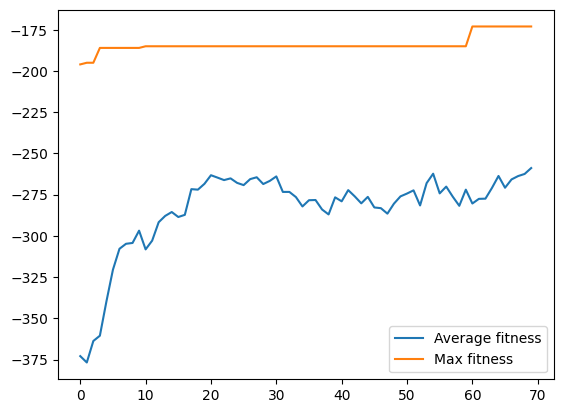

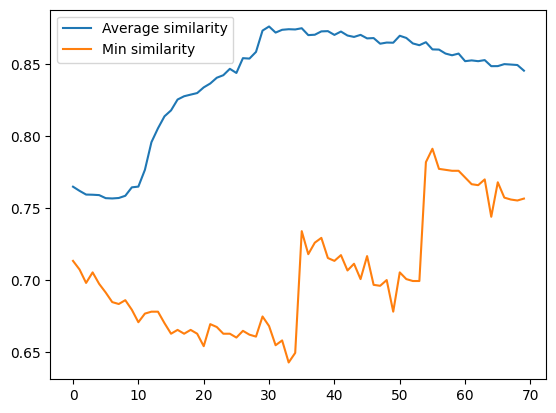

In [ ]:
ea_x.plot_fitness()
ea_x.plot_similarity()

best_solution_x = ea_x.get_best_solution()

plot_atoms(best_solution_x, atom_species_by_index, atom_species_by_symbol)
plot_solution_with_walls((wall_left, wall_right), best_solution_x, atom_species_by_index, atom_species_by_symbol)
plot_neighbourhood_penalties(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_index, atom_species_by_symbol, cluster_size, cluster_size, cluster_size)
plot_distances_penalties(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_index, atom_species_by_symbol)

#### X-axis

In [382]:
wall_left, wall_right = get_positioned_walls_x(er_cluster, cluster_size, wall_thickness, solution_thickness)
wall_left, wall_right = replace_cations_with_Si([wall_left, wall_right], atom_species_by_symbol)

In [383]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=0, 
                                                        n=population_size)

initial_population = replace_cations_with_Si(initial_population, atom_species_by_symbol)

In [384]:
mutation_type = lambda offspring: apply_all_mutations_independently_to_each_gene(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, available_species, axis=0)

In [385]:
crossover = lambda parents: crossover_n_points_random_axis(parents, cluster_size, solution_thickness, 0, n_points=1)

In [386]:
selection = lambda population, fitness_values: selection_proportional(population, fitness_values, n_parents_per_child, n_children, n_elites)

In [387]:
fitness_function = lambda solution: fitness_x(wall_left, wall_right, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

In [388]:
population_gen_to_fen = lambda population_genotypes: population_genotypes_to_fenotypes(population_genotypes)

In [389]:
population_fen_to_gen = lambda population_fenotypes: population_fenotypes_to_genotypes(population_fenotypes, cluster_size, solution_thickness, axis=0, atom_species_by_symbol=atom_species_by_symbol, available_species=available_species)

In [390]:
ea_x = EvolutionaryAlgorithm(initial_population, mutation_type, crossover, selection, fitness_function, population_gen_to_fen, population_fen_to_gen)

In [391]:
new_population = ea_x.evolve(max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -196.92166666666665 best fitness: -101.0
Generation 1 avg fitness: -195.33666666666667 best fitness: -95.0
Generation 2 avg fitness: -189.405 best fitness: -91.0
Generation 3 avg fitness: -181.36 best fitness: -89.0
Generation 4 avg fitness: -175.99 best fitness: -79.0
Generation 5 avg fitness: -170.59833333333333 best fitness: -77.0
Generation 6 avg fitness: -163.94 best fitness: -77.0
Generation 7 avg fitness: -161.12 best fitness: -77.0
Generation 8 avg fitness: -150.38833333333332 best fitness: -59.0
Generation 9 avg fitness: -146.79 best fitness: -58.0
Generation 10 avg fitness: -138.47833333333332 best fitness: -58.0
Generation 11 avg fitness: -134.525 best fitness: -58.0
Generation 12 avg fitness: -129.20333333333335 best fitness: -58.0
Generation 13 avg fitness: -125.08833333333334 best fitness: -55.0
Generation 14 avg fitness: -121.44166666666666 best fitness: -55.0
Generation 15 avg fitness: -118.77166666666666 best fitness: -55.0
Generation 16 avg f

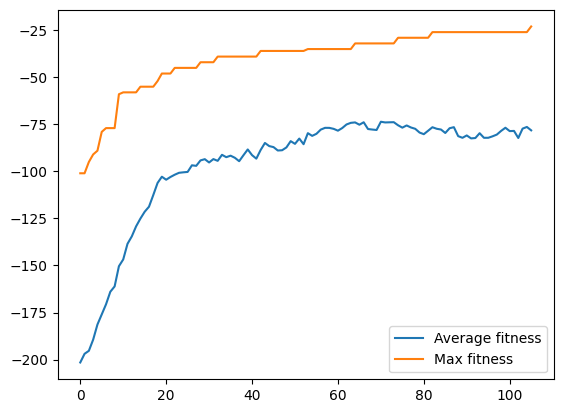

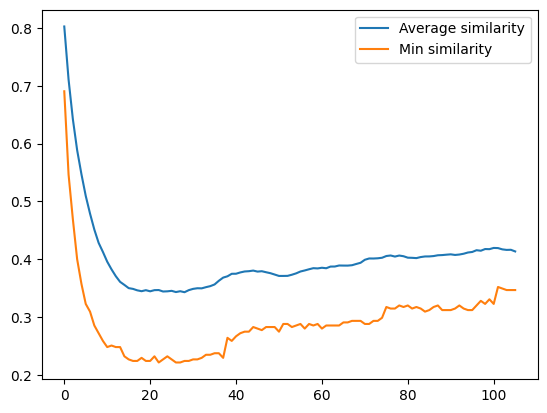

In [392]:
ea_x.plot_fitness()
ea_x.plot_similarity()

best_solution_x = ea_x.get_best_solution()

plot_atoms(best_solution_x, atom_species_by_index, atom_species_by_symbol)
plot_solution_with_walls((wall_left, wall_right), best_solution_x, atom_species_by_index, atom_species_by_symbol)
plot_neighbourhood_penalties(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_index, atom_species_by_symbol, 2*wall_thickness + solution_thickness, cluster_size, cluster_size)
plot_distances_penalties(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_index, atom_species_by_symbol)

In [351]:
fitness_x(wall_left, wall_right, best_solution_x, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

np.float64(-46.0)

In [332]:
atoms = np.concat([wall_left, wall_right, best_solution_x])

size_x = 2 * wall_thickness + solution_thickness
size_y = cluster_size
size_z = cluster_size

center = np.zeros(3)

In [350]:
penalty_neighbourhood(atoms, atom_species_by_symbol, size_x, size_y, size_z, center)

np.float64(4.0)

In [349]:
violations = [violations_by_distance_for_atom_species(atoms, atom_species_by_symbol[first_species], atom_species_by_symbol[second_species], threshold) for first_species, second_species, threshold in checked_distances]
violations

[array([[False, False,  True, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False]]),
 array([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False,  True, False, False],
        [False, False, False, False],
        [False, False, False, False]]

In [339]:
np.triu(violations[0], k=1)

array([[False, False,  True, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]])

In [335]:
penalty_distances(atoms, atom_species_by_symbol)

np.int64(16)

In [121]:
plot_atoms(er_cluster, atom_species_by_index, atom_species_by_symbol)
plot_atoms(wall_left, atom_species_by_index, atom_species_by_symbol)
plot_atoms(wall_right, atom_species_by_index, atom_species_by_symbol)

In [235]:
s_gen = ea_x.population_genotypes[0]
s_fen = genotype_to_fenotype(s_gen)

plot_atoms(s_fen, atom_species_by_index, atom_species_by_symbol)
plot_solution_with_walls((wall_left, wall_right), s_fen, atom_species_by_index, atom_species_by_symbol)
plot_neighbourhood_penalties(np.concat([wall_left, wall_right, s_fen]), atom_species_by_index, atom_species_by_symbol, cluster_size, cluster_size, cluster_size)
plot_distances_penalties(np.concat([wall_left, wall_right, s_fen]), atom_species_by_index, atom_species_by_symbol)

####  Y-axis

In [270]:
wall_down, wall_up = get_positioned_walls_y(best_solution_x, er_cluster, cluster_size, wall_thickness, solution_thickness)
wall_down, wall_up = replace_cations_with_Si([wall_down, wall_up], atom_species_by_symbol)

In [271]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=1, 
                                                        n=population_size)

initial_population = replace_cations_with_Si(initial_population, atom_species_by_symbol)

In [272]:
mutation_type = lambda offspring: apply_single_random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=1)

In [88]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=1)

In [89]:
fitness_function = lambda solution: fitness_y(wall_down, wall_up, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

In [90]:
ea_y = EvolutionaryAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [91]:
new_population = ea_y.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -3890.886033368257 best fitness: -3301.685622471774
Generation 15 avg fitness: -3028.867006601634 best fitness: -2782.6979758192556
Generation 30 avg fitness: -2895.521760194376 best fitness: -2694.4203850637273
Generation 45 avg fitness: -2688.7612591615016 best fitness: -2490.591295815377
Generation 60 avg fitness: -2551.5858647784703 best fitness: -2390.590871467342
Generation 75 avg fitness: -2484.3227603397277 best fitness: -2331.839784063225
Reached stagnation
Evolution ran for  87 generations, reached best fitness of  -2268.9499583124366


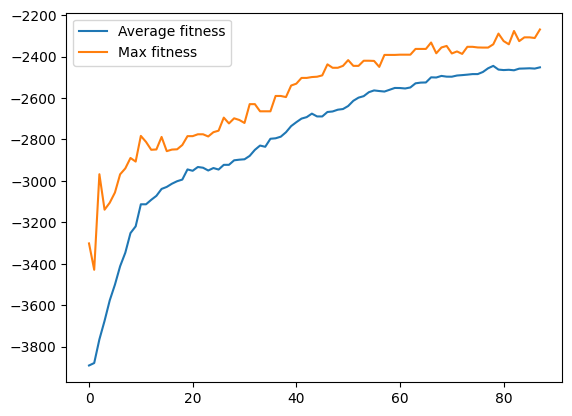

In [92]:
ea_y.plot_fitness()
best_solution_y = ea_y.get_best_solution()

plot_atoms(best_solution_y, atom_species_by_index)
plot_solution_with_walls((wall_down, wall_up), best_solution_y, atom_species_by_index)

####  Z-axis

In [93]:
wall_front, wall_back = get_positioned_walls_z(best_solution_x, best_solution_y, er_cluster, cluster_size, wall_thickness, solution_thickness)
wall_front, wall_back = replace_cations_with_Si([wall_front, wall_back], atom_species_by_symbol)

In [94]:
initial_population = get_n_random_solutions_without_Er(supercell, 
                                                        cell_size, 
                                                        atom_species_by_symbol, 
                                                        cluster_size, 
                                                        solution_thickness, 
                                                        axis=2, 
                                                        n=population_size)

initial_population = replace_cations_with_Si(initial_population, atom_species_by_symbol)

In [95]:
mutation_type = lambda offspring: apply_single_random_mutation(mutation_probabilities, offspring, cluster_size, solution_thickness, atom_species_by_symbol, axis=2)

In [96]:
crossover = lambda parents: crossover_fenotypes(parents, cluster_size, solution_thickness, axis=2)

In [97]:
fitness_function = lambda solution: fitness_z(wall_front, wall_back, solution, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

In [98]:
ea_z = EvolutionaryAlgorithm(initial_population, mutation_type, crossover, selection_proportional, fitness_function)

In [99]:
new_population = ea_z.evolve(n_parents_per_child, n_children, n_elites, max_num_generations, tolerate_stagnation_for_n_generations, stagnation_epsilon, target_fitness_value)

Generation 0 avg fitness: -4864.062567775644 best fitness: -4053.452534567585
Generation 15 avg fitness: -4175.410629039994 best fitness: -3925.984234251252
Generation 30 avg fitness: -3861.8955811778314 best fitness: -3674.630647779744
Generation 45 avg fitness: -3678.880580934246 best fitness: -3515.3300363550925
Generation 60 avg fitness: -3520.798980770777 best fitness: -3331.6964518914547
Generation 75 avg fitness: -3373.637072314719 best fitness: -3224.206848896968
Generation 90 avg fitness: -3258.28998996103 best fitness: -3123.7189324425008
Generation 105 avg fitness: -3082.450485014446 best fitness: -2929.881549444838
Reached stagnation
Evolution ran for  120 generations, reached best fitness of  -2825.5187547750766


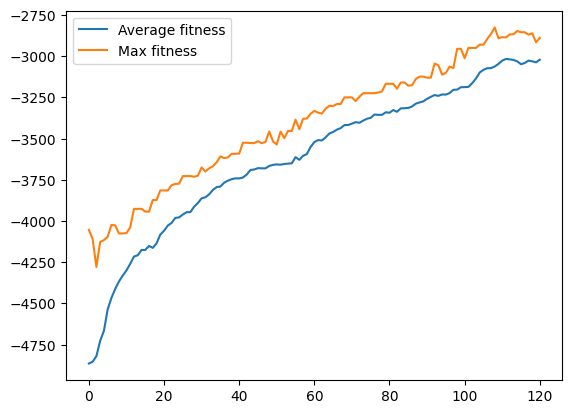

In [104]:
ea_z.plot_fitness()
best_solution_z = ea_z.get_best_solution()

plot_atoms(best_solution_z, atom_species_by_index)
plot_solution_with_walls((wall_front, wall_back), best_solution_z, atom_species_by_index)

In [103]:
plot_atoms(wall_back, atom_species_by_index)

#### Export results

In [53]:
export_to_xcrysden(er_cluster, best_solution_x, best_solution_y, best_solution_z, cluster_size, solution_thickness, atom_species_by_index, 'data/sol.in')

In [54]:
export_to_xcrysden(er_cluster, best_solution_x, None, None, cluster_size, solution_thickness, atom_species_by_index, 'data/sol_x.in')

#### Fitness analysis

In [55]:
fitness_x(wall_left, wall_right, best_solution_x, atom_species_by_symbol, cluster_size, wall_thickness, solution_thickness, alpha, beta, gamma)

np.float64(-891.2421155659964)

In [56]:
penalty_density(np.concat([wall_left, wall_right, best_solution_x]), 2 * wall_thickness + solution_thickness, cluster_size, cluster_size, atom_species_by_symbol)

0.15736659129507888

In [57]:
penalty_distances(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_symbol)

np.float64(23.0)

In [61]:
penalty_angles(np.concat([wall_left, wall_right, best_solution_x]), atom_species_by_symbol)

np.float64(0.0)